In [2]:
import numpy as np
import scipy as sp
import pandas as pd
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg as LA

import time

import logistic_regression as LR
import first_order_method as FOM

import sys
sys.path.insert(0, '/Users/HKim/Desktop/Research/Experiments/libsvm-weights-3.20/python')
from svm import *
from svmutil import *

In [3]:
xx = pd.read_csv('../dataset/original/dataset_statistics.csv')
xx

,file name,# samples (before removing empty rows),# samples (after removing empty rows),# features,classes,# classes,normalized,sparse,comment
0,news20.binary,19996,19954,1355191,"[1.0, -1.0]",2,1,1,NaN
1,covtype.libsvm.binary,581012,581012,54,"[1.0, 2.0]",2,0,1,NaN
2,covtype.libsvm.binary.scale,581012,581012,54,"[1.0, 2.0]",2,0,1,Different from covtype.binary: every feature i...
3,real-sim,72309,72201,20958,"[1.0, -1.0]",2,1,1,NaN
4,rcv1_train.binary,20242,20242,47236,"[1.0, -1.0]",2,1,1,NaN
5,rcv1_test.binary,677399,677399,47236,"[1.0, -1.0]",2,1,1,NaN
6,w1a,2477,2270,300,"[1.0, -1.0]",2,0,1,NaN


In [4]:
def compute_2norm_row(X):
    X_tmp = X.copy()
    X_tmp.data **= 2
    norm_y = sp.sqrt(X_tmp.sum(1))
    return sp.sqrt(X_tmp.sum(1))

In [5]:
def normalize_row(X):
    row_norm = compute_2norm_row(X)
    return sp.sparse.diags([1.0/n[0] for n in row_norm])*X

In [6]:
def data_parsing(X,y):
    # Removing empty data
    empty_idx = []
    for i in xrange(len(X)):
        if len(X[i].keys()) == 0:
            empty_idx.append(i)
            continue
    n_deleted = 0
    for idx in empty_idx:
        del X[idx-n_deleted]
        del y[idx-n_deleted]
        n_deleted += 1

    # The number of samples
    n_samples = len(X)

    # Feature dimension
    dim = max([max(xi.keys()) for xi in X])
    
    # Convert from dictionary to a scipy sparse row matrix
    XX = sp.sparse.dok_matrix((n_samples,dim), dtype=float)
    for i in range(len(X)):
        for key, value in X[i].iteritems():
            XX[i,key-1] = value
    XX = XX.tocsr()
    
    # Normalize feature vectors
    XX = normalize_row(XX)
    return XX, y

In [7]:
# def main():
# Read the data
y_trn, X_trn = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/w1a')
y_tst, X_tst = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/w1a.t')
# y_trn, X_trn = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/rcv1_train.binary')
# y_tst, X_tst = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/rcv1_test.binary')

In [8]:
X_trn, y_trn = data_parsing(X_trn, y_trn)
X_tst, y_tst = data_parsing(X_tst, y_tst)

# The number of samples
n_sample = X_trn.shape[0]

In [9]:
# Define the problem: setting the paramters of logistic regression
data = {'X_train':X_trn, 'y_train':y_trn, 'X_test': X_tst, 'y_test': y_tst}
param_problem = {"lambda":8.0/n_sample}

In [10]:
# Define the solver: setting the paramters of logistic regression
param_solver = {"step-size":'need to change for each algorithm', "# max-pass":1e5, "epsilon":1e-4,
                "result_stored":{'trn_loss':True,'tst_loss':True,'trn_err':True,'tst_err':True,
                                 'norm_grad':True,'n_grad_comp':True}}

In [11]:
# Generate a logistic-regression object.
problem = LR.BinaryLogisticRegression(data, param_problem)

In [12]:
# step-size for GD
eta_gd = 1.0
param_solver['step-size'] = eta_gd

In [13]:
# Generate a solver object: ((full) gradient descent algorithm)
fgd = FOM.FirstOrderMethod(problem, 'fgd', param_solver)

In [14]:
# Do optimization: Solve via the (full) gradient descent algorithm
fgd.do_optimization()

In [16]:
# step-size for SVRG
eta_svrg = 0.5
param_solver['step-size'] = eta_svrg

In [17]:
# Generate a solver object: (SVRG)
svrg = []
problem = LR.BinaryLogisticRegression(data, param_problem)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_solver))
svrg[-1].set_epoch_size(problem.get_n_sample()) # m=n
problem = LR.BinaryLogisticRegression(data, param_problem)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_solver))
svrg[-1].set_epoch_size(problem.get_n_sample()/2) # m=n/2
problem = LR.BinaryLogisticRegression(data, param_problem)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_solver))
svrg[-1].set_epoch_size(problem.get_n_sample()/4) # m=n/4
problem = LR.BinaryLogisticRegression(data, param_problem)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_solver))
svrg[-1].set_epoch_size(problem.get_n_sample()/8) # m=n/8

In [18]:
# Do optimization
epoch_sizes = ['n','n/2','n/4','n/8']
svrg = dict(zip(epoch_sizes, svrg))
for _key_ in epoch_sizes:
    svrg[_key_].do_optimization()

epoch size: n 8.22595787048
epoch size: n/2 7.65070295334
epoch size: n/4 8.63430213928
epoch size: n/8 8.16251707077


In [19]:
# Reshape Update History --> pandas dataframe
update_history = []
gd_history = [('Algorithm', ['GD' for i in fgd.results[fgd.results.keys()[0]]])]
for key2, val2 in fgd.results.iteritems():
    if len(val2): # check if the item is empty or not
        if key2 is 'n_grad_comp':
            key_tmp = 'effective pass'
            val_tmp = [i/float(n_sample) for i in val2]
        else:
            key_tmp = key2
            val_tmp = val2
        gd_history += [(key_tmp,val_tmp)]

# gd_history += [(key,val) for key,val in fgd.results.iteritems() if len(val)]
update_history.append(('GD', pd.DataFrame.from_items(gd_history)))

for key in epoch_sizes:
    val = svrg[key]
    svrg_history = [('Algorithm', ['SVRG (m='+key+')' for i in val.results[val.results.keys()[0]]])]
    for key2, val2 in val.results.iteritems():
        if len(val2): # check if the item is empty or not
            if key2 is 'n_grad_comp':
                effective_pass = [i/float(n_sample) for i in val2]
                svrg_history += [('effective pass',effective_pass)]
                
                # Start computation for PIM
                # Compute # of gradient computations when the computations of full gradient is not taken into account.
                val2
                effective_pass = []
                nn = 0
                for _n_grad_comp_ in val2:
                    effective_pass.append((_n_grad_comp_+nn)/float(n_sample))
                    nn -= n_sample
                # End computation for PIM
                svrg_history += [('effective pass (PIM)',effective_pass)]
            else:
                key_tmp = key2
                val_tmp = val2
                svrg_history += [(key_tmp,val_tmp)]
    update_history.append(('svrg ('+key+')', pd.DataFrame.from_items(svrg_history)))
    
update_history = dict(update_history)

In [21]:
# Save the file in log
update_history['GD']
frames = [update_history['svrg (n)'], update_history['svrg (n/2)'],
          update_history['svrg (n/4)'], update_history['svrg (n/8)'], update_history['GD']]


folder = '../log/'
dataset = 'w1a'
file_name = folder+dataset+'_lam('+str(param_problem["lambda"]*n_sample)+'_n)_etaGD('+str(eta_gd)+')_etaSVRG('+str(eta_svrg)+').csv'


result = pd.concat(frames)
result.to_csv(file_name, index=False)

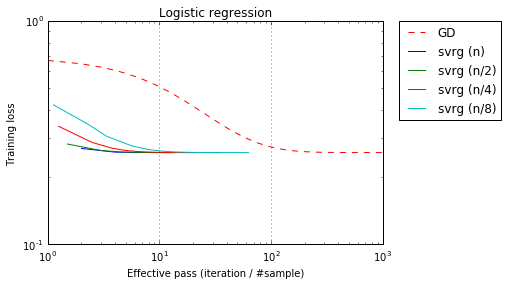

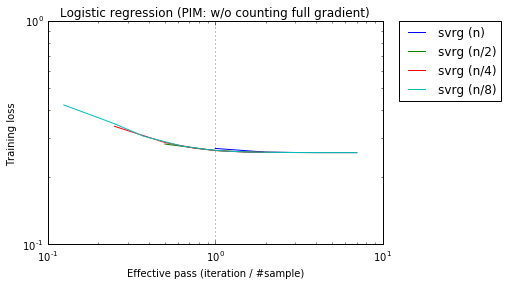

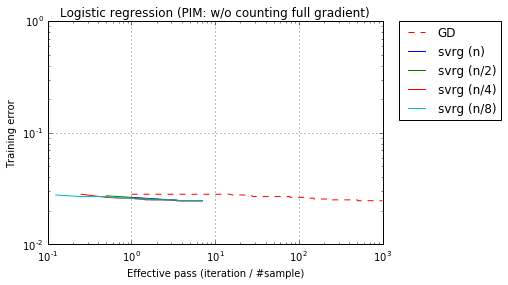

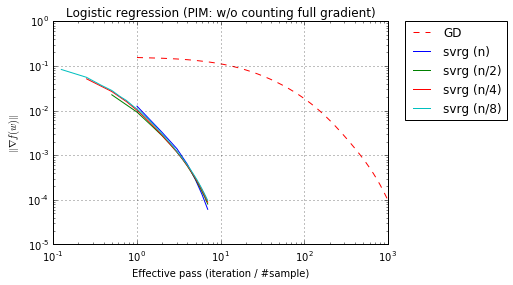

In [22]:
pass_max = max([i['effective pass'].values[-1] for i in update_history.values()])

# Loss
_result_ = 'trn_loss'
plt.figure()
plt.loglog(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    plt.loglog(update_history[_key_]['effective pass'], update_history[_key_][_result_], label=_key_)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-0.01*pass_max, 1.01*pass_max)
plt.grid()
plt.title('Logistic regression')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel('Training loss')

# Loss (PIM)
_result_ = 'trn_loss'
plt.figure()
idx_tmp = update_history['GD']['effective pass'] <= param_solver["# max-pass"]
x = update_history['GD']['effective pass'][idx_tmp]
y = update_history['GD'][_result_][idx_tmp]

# plt.loglog(x, y, 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    idx_tmp = update_history[_key_]['effective pass (PIM)'] <= param_solver["# max-pass"]
    x = update_history[_key_]['effective pass (PIM)'][idx_tmp]
    y = update_history[_key_][_result_][idx_tmp]
    plt.loglog(x,y, label=_key_)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(-0.01*pass_max, 1.01*pass_max)
# plt.ylim(3.5e-1,1e0)
plt.grid()
plt.title('Logistic regression (PIM: w/o counting full gradient)')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel('Training loss')


# Classification error
_result_ = 'trn_err'
plt.figure()
plt.loglog(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    idx_tmp = update_history[_key_]['effective pass (PIM)'] <= param_solver["# max-pass"]
    x = update_history[_key_]['effective pass (PIM)'][idx_tmp]
    y = update_history[_key_][_result_][idx_tmp]
    plt.loglog(x,y, label=_key_)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(-0.01*pass_max, 1.01*pass_max)
plt.grid()
plt.title('Logistic regression (PIM: w/o counting full gradient)')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel('Training error')


# Norm of gradient
_result_ = 'norm_grad'
plt.figure()
plt.loglog(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    plt.loglog(update_history[_key_]['effective pass (PIM)'], update_history[_key_][_result_], label=_key_)
# plt.loglog([-0.01*pass_max, 1.01*pass_max],
#          [param_solver['epsilon'],param_solver['epsilon']], 'r-.',label=r'Thre. of $\| \nabla f(w) \|$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(-0.01*pass_max, 1.01*pass_max)
# plt.ylim(bottom=param_solver['epsilon']/2)
plt.grid()
plt.title('Logistic regression (PIM: w/o counting full gradient)')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel(r'$\| \nabla f(w) \|$')

In [43]:
# if __name__ == '__main__':
#     main()